In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
SIE = pd.read_csv("data/siemens.csv")
DTE = pd.read_csv("data/deutsche-telekom.csv")
ALV = pd.read_csv("data/allianz.csv")
MRK = pd.read_csv("data/merck-kgaa.csv")
DHL = pd.read_csv("data/deutsche-post.csv")

In [3]:
# Change Dtype of Date column
SIE["Date"] = pd.to_datetime(SIE["Date"])
DTE["Date"] = pd.to_datetime(DTE["Date"])
ALV["Date"] = pd.to_datetime(ALV["Date"])
MRK["Date"] = pd.to_datetime(MRK["Date"])
DHL["Date"] = pd.to_datetime(DHL["Date"])

In [4]:
SIE.set_index('Date', inplace=True)
DTE.set_index('Date', inplace=True)
ALV.set_index('Date', inplace=True)
MRK.set_index('Date', inplace=True)
DHL.set_index('Date', inplace=True)

In [5]:
# Set date variable
start_date = '2010-01-04' # Start date of training set
end_date = '2020-09-30' # End date of training set
test_start_date = '2020-10-01' # End date of test set
test_end_date = '2023-06-30' # End date of test set

In [6]:
# Define a function to split data to train set and test set
def split(df, end_date, test_start_date):
    train = df.loc[:end_date]
    test = df.loc[test_start_date:]
    return train, test

In [7]:
# Define a function to split data to train set and validation set
def split_val(data, rate):
    idx = int(len(data) * rate)
    train = data[:idx]
    val = data[idx:]
    return train, val

In [8]:
# Define a function to process data (Mehtab et al., 2021)
def Dataset(Data, number_features):

    Train_Data = Data.to_numpy()
    Data_Train = []
    Data_Train_X = []
    Data_Train_Y = []
    for i in range(0, len(Train_Data), 5):
        if len(Train_Data[i : i + 5]) == 5:
            Data_Train.append(Train_Data[i : i + 5])

    if len(Data_Train[-1]) < 5:
        Data_Train.pop(-1)

    Data_Train_X = Data_Train[0 : -1]
    Data_Train_X = np.array(Data_Train_X)
    Data_Train_X = Data_Train_X.reshape((-1, 5, number_features))
    
    Train_Label = Data['Close'].to_numpy()
    for i in range(0, len(Train_Label), 5):
        if len(Train_Label[i : i + 5]) == 5:
            Data_Train_Y.append(Train_Label[i : i + 5])
    
    if len(Data_Train_Y[-1]) < 5:
        Data_Train_Y.pop(-1)
    Data_Train_Y = Data_Train_Y[1 : len(Data_Train_Y)]
    Data_Train_Y = np.array(Data_Train_Y)
    Data_Train_Y = Data_Train_Y.reshape((-1, 5, 1))
    
    return Data_Train_X, Data_Train_Y

In [9]:
def scheduler(epoch):
    if epoch <= 150:
        lrate = (10 ** -5) * (epoch / 150) 
    elif epoch <= 400:
        initial_lrate = (10 ** -5)
        k = 0.01
        lrate = initial_lrate * math.exp(-k * (epoch - 150))
    else:
        lrate = (10 ** -6)
    return lrate

# 1. Features = {price}

## 1.1. SIE

In [10]:
SIE

,Open,High,Low,Close,Volume,Dividends,Stock Splits,pe-ratio,ps-ratio,pb-ratio,Ticker
Date,,,,,,,,,,,
2010-01-04,39.453722,39.898530,39.362323,39.892437,2734897.0,0.0,0.0,21.092000,0.762592,1.938798,siemens
2010-01-05,39.849782,40.148349,39.593865,39.916805,2584717.0,0.0,0.0,21.092000,0.762592,1.938798,siemens
2010-01-06,39.880244,40.130068,39.752286,40.063042,2166413.0,0.0,0.0,21.092000,0.762592,1.938798,siemens
2010-01-07,40.032576,40.702835,39.709636,40.538315,3336865.0,0.0,0.0,21.092000,0.762592,1.938798,siemens
2010-01-08,40.733299,40.964843,40.325055,40.794235,2634386.0,0.0,0.0,21.092000,0.762592,1.938798,siemens
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,157.399994,157.699997,155.320007,155.479996,1312767.0,0.0,0.0,19.691292,1.515738,1.998793,siemens
2023-06-27,156.399994,158.039993,155.979996,157.559998,1065494.0,0.0,0.0,19.691292,1.515738,1.998793,siemens
2023-06-28,158.940002,159.639999,150.399994,152.720001,2094689.0,0.0,0.0,19.691292,1.515738,1.998793,siemens


In [11]:
SIE.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3449 entries, 2010-01-04 to 2023-06-30
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3449 non-null   float64
 1   High          3449 non-null   float64
 2   Low           3449 non-null   float64
 3   Close         3449 non-null   float64
 4   Volume        3449 non-null   float64
 5   Dividends     3449 non-null   float64
 6   Stock Splits  3449 non-null   float64
 7   pe-ratio      3449 non-null   float64
 8   ps-ratio      3449 non-null   float64
 9   pb-ratio      3449 non-null   float64
 10  Ticker        3449 non-null   object 
dtypes: float64(10), object(1)
memory usage: 323.3+ KB


In [12]:
SIE_df1 = SIE[["Close"]]
SIE_df1

,Close
Date,
2010-01-04,39.892437
2010-01-05,39.916805
2010-01-06,40.063042
2010-01-07,40.538315
2010-01-08,40.794235
...,...
2023-06-26,155.479996
2023-06-27,157.559998
2023-06-28,152.720001


### Data Proprocessing

In [13]:
# Split data to train set and test set
train, test = split(SIE_df1, end_date, test_start_date)

In [14]:
# Reconcile length of data set and subsets
SIE_df1.shape[0] == train.shape[0] + test.shape[0]

True

In [15]:
# Process data
X_train, y_train = Dataset(train, 1)
X_test, y_test = Dataset(test, 1)

In [16]:
# Split train set to train set and validation set
X_train, X_val = split_val(X_train, 0.8)
y_train, y_val = split_val(y_train, 0.8)

### Model

In [17]:
# Define model (Mehtab et al., 2021)
def Model():
    model = tf.keras.models.Sequential([
                                      tf.keras.layers.LSTM(200, input_shape = (5, 1), activation = tf.nn.leaky_relu, return_sequences = True),
                                      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(300, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(5, activation = tf.nn.leaky_relu)
                                      ])
    return model

In [18]:
model = Model()

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 200)            161600    
                                                                 
 lstm_1 (LSTM)               (None, 200)               320800    
                                                                 
 dense (Dense)               (None, 300)               60300     
                                                                 
 dense_1 (Dense)             (None, 200)               60200     
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dense_3 (Dense)             (None, 50)                5050      
                                                                 
 dense_4 (Dense)             (None, 5)                 2

### Custom Learning Rate

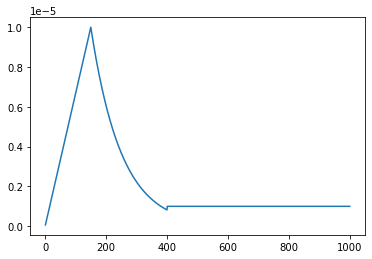

In [20]:
epochs = [i for i in range(1, 1001, 1)]
lrate = [scheduler(i) for i in range(1, 1001, 1)]
plt.plot(epochs, lrate)

In [21]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

### Learning

In [22]:
# Compile model (Mehtab et al., 2021)
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [23]:
# Fit model (Mehtab et al., 2021)
hist = model.fit(X_train, y_train, epochs = 200, validation_data = (X_val, y_val), callbacks=[callback])

Epoch 1/200
14/14 [==============================] - 5s 68ms/step - loss: 4998.8169 - root_mean_squared_error: 70.7023 - val_loss: 8319.9453 - val_root_mean_squared_error: 91.2137 - lr: 0.0000e+00
Epoch 2/200
14/14 [==============================] - 0s 22ms/step - loss: 4998.7354 - root_mean_squared_error: 70.7017 - val_loss: 8319.6426 - val_root_mean_squared_error: 91.2121 - lr: 6.6667e-08
Epoch 3/200
14/14 [==============================] - 0s 26ms/step - loss: 4998.4727 - root_mean_squared_error: 70.6999 - val_loss: 8319.0342 - val_root_mean_squared_error: 91.2087 - lr: 1.3333e-07
Epoch 4/200
14/14 [==============================] - 0s 25ms/step - loss: 4998.0215 - root_mean_squared_error: 70.6967 - val_loss: 8318.1426 - val_root_mean_squared_error: 91.2038 - lr: 2.0000e-07
Epoch 5/200
14/14 [==============================] - 0s 25ms/step - loss: 4997.3896 - root_mean_squared_error: 70.6922 - val_loss: 8316.9248 - val_root_mean_squared_error: 91.1972 - lr: 2.6667e-07
Epoch 6/200
14/

Epoch 84/200
14/14 [==============================] - 0s 29ms/step - loss: 24.8571 - root_mean_squared_error: 4.9857 - val_loss: 34.5035 - val_root_mean_squared_error: 5.8740 - lr: 5.5333e-06
Epoch 85/200
14/14 [==============================] - 0s 26ms/step - loss: 22.0182 - root_mean_squared_error: 4.6924 - val_loss: 30.8806 - val_root_mean_squared_error: 5.5570 - lr: 5.6000e-06
Epoch 86/200
14/14 [==============================] - 0s 28ms/step - loss: 19.6129 - root_mean_squared_error: 4.4286 - val_loss: 28.9775 - val_root_mean_squared_error: 5.3831 - lr: 5.6667e-06
Epoch 87/200
14/14 [==============================] - 0s 28ms/step - loss: 17.5750 - root_mean_squared_error: 4.1923 - val_loss: 27.8249 - val_root_mean_squared_error: 5.2749 - lr: 5.7333e-06
Epoch 88/200
14/14 [==============================] - 0s 27ms/step - loss: 15.7308 - root_mean_squared_error: 3.9662 - val_loss: 25.1453 - val_root_mean_squared_error: 5.0145 - lr: 5.8000e-06
Epoch 89/200
14/14 [====================

Epoch 127/200
14/14 [==============================] - 0s 28ms/step - loss: 5.9395 - root_mean_squared_error: 2.4371 - val_loss: 18.0194 - val_root_mean_squared_error: 4.2449 - lr: 8.4000e-06
Epoch 128/200
14/14 [==============================] - 0s 27ms/step - loss: 5.9279 - root_mean_squared_error: 2.4347 - val_loss: 17.9688 - val_root_mean_squared_error: 4.2390 - lr: 8.4667e-06
Epoch 129/200
14/14 [==============================] - 0s 26ms/step - loss: 5.8950 - root_mean_squared_error: 2.4280 - val_loss: 17.9500 - val_root_mean_squared_error: 4.2367 - lr: 8.5333e-06
Epoch 130/200
14/14 [==============================] - 0s 28ms/step - loss: 5.8679 - root_mean_squared_error: 2.4224 - val_loss: 17.9251 - val_root_mean_squared_error: 4.2338 - lr: 8.6000e-06
Epoch 131/200
14/14 [==============================] - 0s 27ms/step - loss: 5.8509 - root_mean_squared_error: 2.4189 - val_loss: 17.9202 - val_root_mean_squared_error: 4.2332 - lr: 8.6667e-06
Epoch 132/200
14/14 [===================

Epoch 170/200
14/14 [==============================] - 0s 28ms/step - loss: 5.3966 - root_mean_squared_error: 2.3231 - val_loss: 17.0861 - val_root_mean_squared_error: 4.1335 - lr: 8.2696e-06
Epoch 171/200
14/14 [==============================] - 0s 28ms/step - loss: 5.3823 - root_mean_squared_error: 2.3200 - val_loss: 17.0083 - val_root_mean_squared_error: 4.1241 - lr: 8.1873e-06
Epoch 172/200
14/14 [==============================] - 0s 29ms/step - loss: 5.3680 - root_mean_squared_error: 2.3169 - val_loss: 17.0263 - val_root_mean_squared_error: 4.1263 - lr: 8.1058e-06
Epoch 173/200
14/14 [==============================] - 0s 28ms/step - loss: 5.3755 - root_mean_squared_error: 2.3185 - val_loss: 16.9631 - val_root_mean_squared_error: 4.1186 - lr: 8.0252e-06
Epoch 174/200
14/14 [==============================] - 0s 26ms/step - loss: 5.3580 - root_mean_squared_error: 2.3147 - val_loss: 16.9475 - val_root_mean_squared_error: 4.1167 - lr: 7.9453e-06
Epoch 175/200
14/14 [===================

In [24]:
history_dict = hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

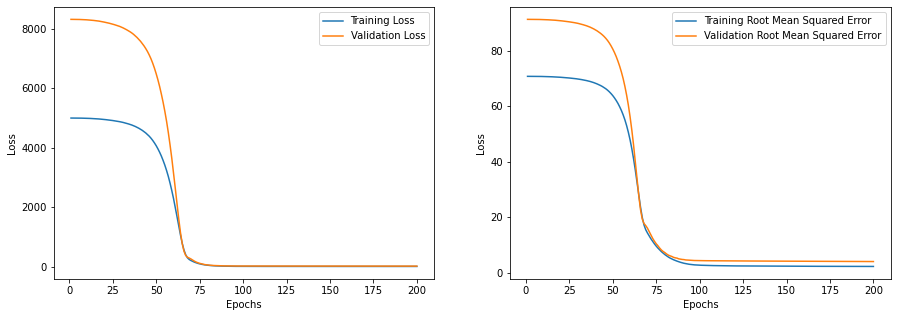

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Prediction

In [26]:
prediction = model.predict(X_test)

5/5 [==============================] - 1s 8ms/step


In [27]:
prediction.shape

(139, 5)

In [28]:
len(prediction.reshape(-1))

695

In [29]:
temp1 = test.tail(695)

In [30]:
temp1['Forecast'] = prediction.reshape(-1)

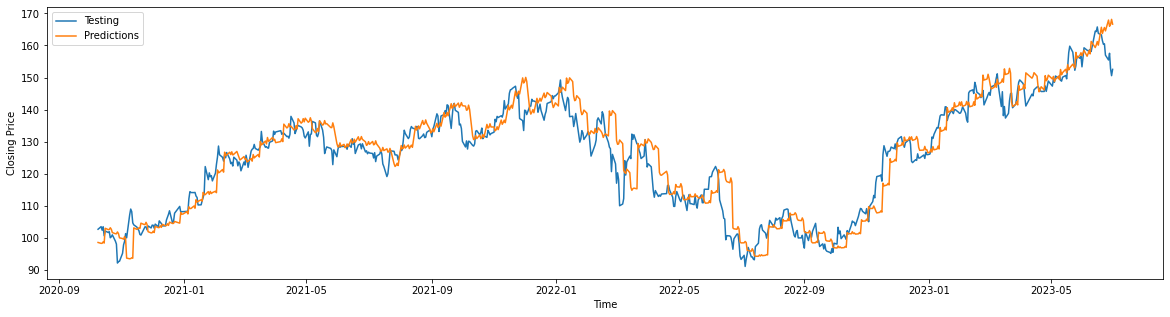

In [31]:
plt.figure(figsize=(20, 5))
plt.plot(temp1['Close'], label = 'Testing')
plt.plot(temp1['Forecast'], label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [32]:
rmse = math.sqrt(mean_squared_error(y_test.reshape(-1, 5), prediction))
mape = np.mean(np.abs(prediction - y_test.reshape(-1, 5))/np.abs(y_test.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 5.183868470958043
MAPE: 0.03116155269497856


In [33]:
temp1

,Close,Forecast
Date,,
2020-10-09,102.678017,98.552742
2020-10-12,103.487961,98.272644
2020-10-13,102.383484,98.294487
2020-10-14,103.451141,98.746552
2020-10-15,100.634758,98.372292
...,...,...
2023-06-26,155.479996,167.921677
2023-06-27,157.559998,165.978867
2023-06-28,152.720001,166.570953


In [34]:
# Create a dataframe that has same index as SIE dataframe
result1 = pd.DataFrame(index=SIE.index)
# Extract actual data from SIE
tem1 = SIE['Close'].tolist()[:len(SIE)-695]
# Extract forecasted date from above result
tem2 = temp1['Forecast'].tolist()
# Combine them to a list
tem3 = tem1 + tem2
# Create a column from the resulted list
result1['SIE'] = tem3
# Mark forecasted or not for each line
result1['Forecasted'] = 'N'
result1.loc[result1.index[-695:], 'Forecasted'] = 'Y'

In [35]:
result1

,SIE,Forecasted
Date,,
2010-01-04,39.892437,N
2010-01-05,39.916805,N
2010-01-06,40.063042,N
2010-01-07,40.538315,N
2010-01-08,40.794235,N
...,...,...
2023-06-26,167.921677,Y
2023-06-27,165.978867,Y
2023-06-28,166.570953,Y


## 1.2. DTE

In [36]:
DTE

,Open,High,Low,Close,Volume,Dividends,Stock Splits,pe-ratio,ps-ratio,pb-ratio,Ticker
Date,,,,,,,,,,,
2010-01-04,4.826971,4.953136,4.817626,4.953136,14257860.0,0.0,0.0,128.625000,0.707311,1.070129,deutsche-telekom
2010-01-05,4.948465,4.953138,4.871364,4.911083,14077418.0,0.0,0.0,128.625000,0.707311,1.070129,deutsche-telekom
2010-01-06,4.831645,4.833982,4.770899,4.789590,28100490.0,0.0,0.0,128.625000,0.707311,1.070129,deutsche-telekom
2010-01-07,4.766226,4.770899,4.663425,4.698472,21799244.0,0.0,0.0,128.625000,0.707311,1.070129,deutsche-telekom
2010-01-08,4.707817,4.728844,4.668565,4.724171,20945576.0,0.0,0.0,128.625000,0.707311,1.070129,deutsche-telekom
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,19.528000,19.733999,19.493999,19.695999,6407184.0,0.0,0.0,5.658228,1.014428,1.057418,deutsche-telekom
2023-06-27,19.830000,19.968000,19.712000,19.906000,0.0,0.0,0.0,5.658228,1.014428,1.057418,deutsche-telekom
2023-06-28,20.000000,20.155001,19.927999,20.030001,8299496.0,0.0,0.0,5.658228,1.014428,1.057418,deutsche-telekom


In [37]:
DTE.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3449 entries, 2010-01-04 to 2023-06-30
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3449 non-null   float64
 1   High          3449 non-null   float64
 2   Low           3449 non-null   float64
 3   Close         3449 non-null   float64
 4   Volume        3449 non-null   float64
 5   Dividends     3449 non-null   float64
 6   Stock Splits  3449 non-null   float64
 7   pe-ratio      3449 non-null   float64
 8   ps-ratio      3449 non-null   float64
 9   pb-ratio      3449 non-null   float64
 10  Ticker        3449 non-null   object 
dtypes: float64(10), object(1)
memory usage: 323.3+ KB


In [38]:
DTE_df1 = DTE[["Close"]]
DTE_df1

,Close
Date,
2010-01-04,4.953136
2010-01-05,4.911083
2010-01-06,4.789590
2010-01-07,4.698472
2010-01-08,4.724171
...,...
2023-06-26,19.695999
2023-06-27,19.906000
2023-06-28,20.030001


### Data Proprocessing

In [39]:
# Split data to train set and test set
train, test = split(DTE_df1, end_date, test_start_date)

In [40]:
# Reconcile length of data set and subsets
DTE_df1.shape[0] == train.shape[0] + test.shape[0]

True

In [41]:
# Process data
X_train, y_train = Dataset(train, 1)
X_test, y_test = Dataset(test, 1)

In [42]:
# Split train set to train set and validation set
X_train, X_val = split_val(X_train, 0.8)
y_train, y_val = split_val(y_train, 0.8)

### Model

In [43]:
# Define model (Mehtab et al., 2021)
def Model():
    model = tf.keras.models.Sequential([
                                      tf.keras.layers.LSTM(200, input_shape = (5, 1), activation = tf.nn.leaky_relu, return_sequences = True),
                                      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(5, activation = tf.nn.leaky_relu)
                                      ])
    return model

In [44]:
model = Model()

In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 5, 200)            161600    
                                                                 
 lstm_3 (LSTM)               (None, 200)               320800    
                                                                 
 dense_5 (Dense)             (None, 200)               40200     
                                                                 
 dense_6 (Dense)             (None, 100)               20100     
                                                                 
 dense_7 (Dense)             (None, 5)                 505       
                                                                 
Total params: 543,205
Trainable params: 543,205
Non-trainable params: 0
_________________________________________________________________


### Custom Learning Rate

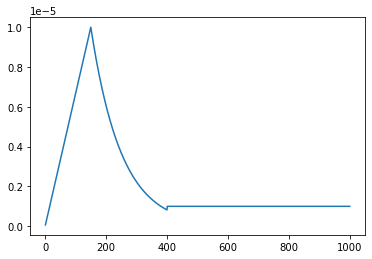

In [46]:
epochs = [i for i in range(1, 1001, 1)]
lrate = [scheduler(i) for i in range(1, 1001, 1)]
plt.plot(epochs, lrate)

In [47]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

### Learning

In [48]:
# Compile model (Mehtab et al., 2021)
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [49]:
# Fit model (Mehtab et al., 2021)
hist = model.fit(X_train, y_train, epochs = 200, validation_data = (X_val, y_val), callbacks=[callback])

Epoch 1/200
14/14 [==============================] - 4s 54ms/step - loss: 69.1606 - root_mean_squared_error: 8.3163 - val_loss: 145.9355 - val_root_mean_squared_error: 12.0804 - lr: 0.0000e+00
Epoch 2/200
14/14 [==============================] - 0s 22ms/step - loss: 69.1599 - root_mean_squared_error: 8.3162 - val_loss: 145.9323 - val_root_mean_squared_error: 12.0802 - lr: 6.6667e-08
Epoch 3/200
14/14 [==============================] - 0s 24ms/step - loss: 69.1577 - root_mean_squared_error: 8.3161 - val_loss: 145.9260 - val_root_mean_squared_error: 12.0800 - lr: 1.3333e-07
Epoch 4/200
14/14 [==============================] - 0s 21ms/step - loss: 69.1540 - root_mean_squared_error: 8.3159 - val_loss: 145.9165 - val_root_mean_squared_error: 12.0796 - lr: 2.0000e-07
Epoch 5/200
14/14 [==============================] - 0s 21ms/step - loss: 69.1488 - root_mean_squared_error: 8.3156 - val_loss: 145.9037 - val_root_mean_squared_error: 12.0791 - lr: 2.6667e-07
Epoch 6/200
14/14 [================

14/14 [==============================] - 0s 26ms/step - loss: 21.6778 - root_mean_squared_error: 4.6559 - val_loss: 22.3866 - val_root_mean_squared_error: 4.7314 - lr: 5.6000e-06
Epoch 86/200
14/14 [==============================] - 0s 27ms/step - loss: 17.7222 - root_mean_squared_error: 4.2098 - val_loss: 14.0539 - val_root_mean_squared_error: 3.7488 - lr: 5.6667e-06
Epoch 87/200
14/14 [==============================] - 0s 26ms/step - loss: 14.0054 - root_mean_squared_error: 3.7424 - val_loss: 7.5397 - val_root_mean_squared_error: 2.7458 - lr: 5.7333e-06
Epoch 88/200
14/14 [==============================] - 0s 26ms/step - loss: 10.7436 - root_mean_squared_error: 3.2777 - val_loss: 3.7116 - val_root_mean_squared_error: 1.9265 - lr: 5.8000e-06
Epoch 89/200
14/14 [==============================] - 0s 26ms/step - loss: 8.2182 - root_mean_squared_error: 2.8667 - val_loss: 2.8065 - val_root_mean_squared_error: 1.6753 - lr: 5.8667e-06
Epoch 90/200
14/14 [==============================] - 0s 

Epoch 128/200
14/14 [==============================] - 0s 26ms/step - loss: 3.1105 - root_mean_squared_error: 1.7637 - val_loss: 7.8055 - val_root_mean_squared_error: 2.7938 - lr: 8.4667e-06
Epoch 129/200
14/14 [==============================] - 0s 27ms/step - loss: 3.0575 - root_mean_squared_error: 1.7486 - val_loss: 7.4295 - val_root_mean_squared_error: 2.7257 - lr: 8.5333e-06
Epoch 130/200
14/14 [==============================] - 0s 25ms/step - loss: 3.0055 - root_mean_squared_error: 1.7336 - val_loss: 7.3933 - val_root_mean_squared_error: 2.7191 - lr: 8.6000e-06
Epoch 131/200
14/14 [==============================] - 0s 24ms/step - loss: 2.9516 - root_mean_squared_error: 1.7180 - val_loss: 7.3712 - val_root_mean_squared_error: 2.7150 - lr: 8.6667e-06
Epoch 132/200
14/14 [==============================] - 0s 25ms/step - loss: 2.9007 - root_mean_squared_error: 1.7031 - val_loss: 7.0386 - val_root_mean_squared_error: 2.6530 - lr: 8.7333e-06
Epoch 133/200
14/14 [========================

Epoch 171/200
14/14 [==============================] - 0s 26ms/step - loss: 1.0105 - root_mean_squared_error: 1.0053 - val_loss: 2.4066 - val_root_mean_squared_error: 1.5513 - lr: 8.1873e-06
Epoch 172/200
14/14 [==============================] - 0s 26ms/step - loss: 0.9806 - root_mean_squared_error: 0.9903 - val_loss: 2.5003 - val_root_mean_squared_error: 1.5812 - lr: 8.1058e-06
Epoch 173/200
14/14 [==============================] - 0s 27ms/step - loss: 0.9498 - root_mean_squared_error: 0.9746 - val_loss: 2.3066 - val_root_mean_squared_error: 1.5188 - lr: 8.0252e-06
Epoch 174/200
14/14 [==============================] - 0s 27ms/step - loss: 0.9208 - root_mean_squared_error: 0.9596 - val_loss: 2.2217 - val_root_mean_squared_error: 1.4906 - lr: 7.9453e-06
Epoch 175/200
14/14 [==============================] - 0s 27ms/step - loss: 0.8933 - root_mean_squared_error: 0.9451 - val_loss: 2.2441 - val_root_mean_squared_error: 1.4980 - lr: 7.8663e-06
Epoch 176/200
14/14 [========================

In [50]:
history_dict = hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

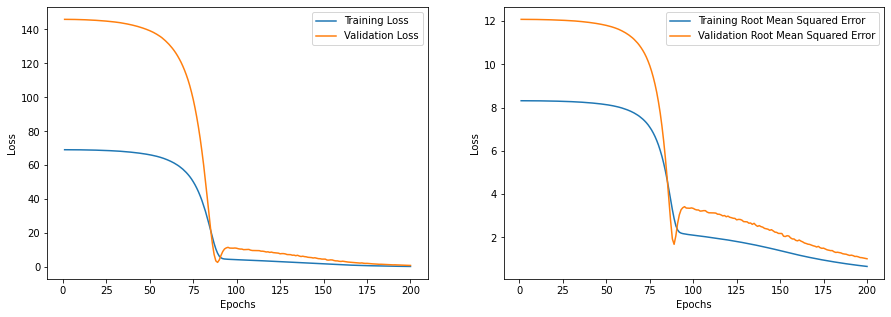

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Prediction

In [52]:
prediction = model.predict(X_test)

5/5 [==============================] - 0s 8ms/step


In [53]:
len(prediction.reshape(-1))

695

In [54]:
temp1 = test.tail(695)

In [55]:
temp1['Forecast'] = prediction.reshape(-1)

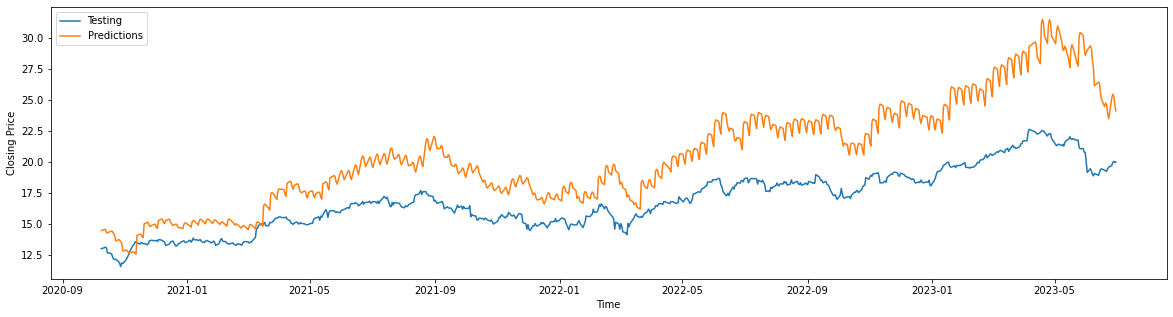

In [56]:
plt.figure(figsize=(20, 5))
plt.plot(temp1['Close'], label = 'Testing')
plt.plot(temp1['Forecast'], label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [57]:
rmse = math.sqrt(mean_squared_error(y_test.reshape(-1, 5), prediction))
mape = np.mean(np.abs(prediction - y_test.reshape(-1, 5))/np.abs(y_test.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 4.126564291878016
MAPE: 0.20794205664053975


In [58]:
temp1

,Close,Forecast
Date,,
2020-10-09,12.981357,14.444920
2020-10-12,13.067026,14.542068
2020-10-13,13.107607,14.517660
2020-10-14,13.053500,14.317676
2020-10-15,12.643183,14.236644
...,...,...
2023-06-26,19.695999,25.142923
2023-06-27,19.906000,25.438316
2023-06-28,20.030001,25.285627


In [59]:
# Extract actual data from SIE
tem1 = DTE['Close'].tolist()[:len(DTE)-695]
# Extract forecasted date from above result
tem2 = temp1['Forecast'].tolist()
# Combine them to a list
tem3 = tem1 + tem2
# Create a column from the resulted list
result1['DTE'] = tem3

In [60]:
result1

,SIE,Forecasted,DTE
Date,,,
2010-01-04,39.892437,N,4.953136
2010-01-05,39.916805,N,4.911083
2010-01-06,40.063042,N,4.789590
2010-01-07,40.538315,N,4.698472
2010-01-08,40.794235,N,4.724171
...,...,...,...
2023-06-26,167.921677,Y,25.142923
2023-06-27,165.978867,Y,25.438316
2023-06-28,166.570953,Y,25.285627


## 1.3. ALV

In [61]:
ALV

,Open,High,Low,Close,Volume,Dividends,Stock Splits,pe-ratio,ps-ratio,pb-ratio,Ticker
Date,,,,,,,,,,,
2010-01-04,45.138680,45.699056,45.035857,45.519119,1676777.0,0.0,0.0,9.154412,0.706716,1.292624,allianz
2010-01-05,45.498549,46.110338,45.395729,45.657921,1742206.0,0.0,0.0,9.154412,0.706716,1.292624,allianz
2010-01-06,45.832728,46.161757,45.627084,46.012665,1362139.0,0.0,0.0,9.154412,0.706716,1.292624,allianz
2010-01-07,45.714478,45.981817,45.421437,45.483131,1926360.0,0.0,0.0,9.154412,0.706716,1.292624,allianz
2010-01-08,45.848145,45.848145,44.562875,45.236355,2425290.0,0.0,0.0,9.154412,0.706716,1.292624,allianz
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,209.800003,209.800003,207.699997,209.199997,532054.0,0.0,0.0,10.264393,0.759921,1.461468,allianz
2023-06-27,210.149994,211.449997,209.649994,211.300003,640049.0,0.0,0.0,10.264393,0.759921,1.461468,allianz
2023-06-28,212.000000,212.800003,210.750000,211.649994,575057.0,0.0,0.0,10.264393,0.759921,1.461468,allianz


In [62]:
ALV.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3449 entries, 2010-01-04 to 2023-06-30
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3449 non-null   float64
 1   High          3449 non-null   float64
 2   Low           3449 non-null   float64
 3   Close         3449 non-null   float64
 4   Volume        3449 non-null   float64
 5   Dividends     3449 non-null   float64
 6   Stock Splits  3449 non-null   float64
 7   pe-ratio      3449 non-null   float64
 8   ps-ratio      3449 non-null   float64
 9   pb-ratio      3449 non-null   float64
 10  Ticker        3449 non-null   object 
dtypes: float64(10), object(1)
memory usage: 323.3+ KB


In [63]:
ALV_df1 = ALV[["Close"]]
ALV_df1

,Close
Date,
2010-01-04,45.519119
2010-01-05,45.657921
2010-01-06,46.012665
2010-01-07,45.483131
2010-01-08,45.236355
...,...
2023-06-26,209.199997
2023-06-27,211.300003
2023-06-28,211.649994


### Data Proprocessing

In [64]:
# Split data to train set and test set
train, test = split(ALV_df1, end_date, test_start_date)

In [65]:
# Reconcile length of data set and subsets
ALV_df1.shape[0] == train.shape[0] + test.shape[0]

True

In [66]:
# Process data
X_train, y_train = Dataset(train, 1)
X_test, y_test = Dataset(test, 1)

In [67]:
# Split train set to train set and validation set
X_train, X_val = split_val(X_train, 0.8)
y_train, y_val = split_val(y_train, 0.8)

### Model

In [68]:
# Define model (Mehtab et al., 2021)
def Model():
    model = tf.keras.models.Sequential([
                                      tf.keras.layers.LSTM(200, input_shape = (5, 1), activation = tf.nn.leaky_relu, return_sequences = True),
                                      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(5, activation = tf.nn.leaky_relu)
                                      ])
    return model

In [69]:
model = Model()

In [70]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 200)            161600    
                                                                 
 lstm_5 (LSTM)               (None, 200)               320800    
                                                                 
 dense_8 (Dense)             (None, 200)               40200     
                                                                 
 dense_9 (Dense)             (None, 100)               20100     
                                                                 
 dense_10 (Dense)            (None, 50)                5050      
                                                                 
 dense_11 (Dense)            (None, 5)                 255       
                                                                 
Total params: 548,005
Trainable params: 548,005
Non-tr

### Custom Learning Rate

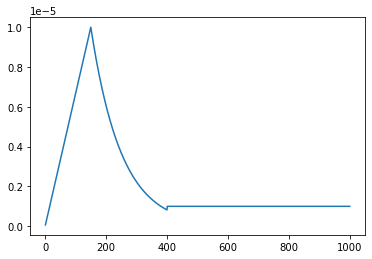

In [71]:
epochs = [i for i in range(1, 1001, 1)]
lrate = [scheduler(i) for i in range(1, 1001, 1)]
plt.plot(epochs, lrate)

In [72]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

### Learning

In [73]:
# Compile model (Mehtab et al., 2021)
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [74]:
# Fit model (Mehtab et al., 2021)
hist = model.fit(X_train, y_train, epochs = 200, validation_data = (X_val, y_val), callbacks=[callback])

Epoch 1/200
14/14 [==============================] - 4s 71ms/step - loss: 7814.3408 - root_mean_squared_error: 88.3988 - val_loss: 24350.7168 - val_root_mean_squared_error: 156.0472 - lr: 0.0000e+00
Epoch 2/200
14/14 [==============================] - 0s 25ms/step - loss: 7814.2021 - root_mean_squared_error: 88.3980 - val_loss: 24349.7461 - val_root_mean_squared_error: 156.0441 - lr: 6.6667e-08
Epoch 3/200
14/14 [==============================] - 0s 29ms/step - loss: 7813.7529 - root_mean_squared_error: 88.3954 - val_loss: 24347.8047 - val_root_mean_squared_error: 156.0378 - lr: 1.3333e-07
Epoch 4/200
14/14 [==============================] - 0s 29ms/step - loss: 7812.9834 - root_mean_squared_error: 88.3911 - val_loss: 24344.9277 - val_root_mean_squared_error: 156.0286 - lr: 2.0000e-07
Epoch 5/200
14/14 [==============================] - 0s 28ms/step - loss: 7811.9463 - root_mean_squared_error: 88.3852 - val_loss: 24340.8750 - val_root_mean_squared_error: 156.0156 - lr: 2.6667e-07
Epoch

14/14 [==============================] - 0s 30ms/step - loss: 7180.1562 - root_mean_squared_error: 84.7358 - val_loss: 22030.3340 - val_root_mean_squared_error: 148.4262 - lr: 2.7333e-06
Epoch 43/200
14/14 [==============================] - 0s 30ms/step - loss: 7130.8857 - root_mean_squared_error: 84.4446 - val_loss: 21848.5918 - val_root_mean_squared_error: 147.8127 - lr: 2.8000e-06
Epoch 44/200
14/14 [==============================] - 0s 30ms/step - loss: 7077.2681 - root_mean_squared_error: 84.1265 - val_loss: 21652.6289 - val_root_mean_squared_error: 147.1483 - lr: 2.8667e-06
Epoch 45/200
14/14 [==============================] - 0s 31ms/step - loss: 7019.3931 - root_mean_squared_error: 83.7818 - val_loss: 21438.5645 - val_root_mean_squared_error: 146.4191 - lr: 2.9333e-06
Epoch 46/200
14/14 [==============================] - 0s 32ms/step - loss: 6957.1694 - root_mean_squared_error: 83.4097 - val_loss: 21205.9297 - val_root_mean_squared_error: 145.6226 - lr: 3.0000e-06
Epoch 47/200


Epoch 126/200
14/14 [==============================] - 0s 31ms/step - loss: 8.5293 - root_mean_squared_error: 2.9205 - val_loss: 62.8043 - val_root_mean_squared_error: 7.9249 - lr: 8.3333e-06
Epoch 127/200
14/14 [==============================] - 0s 28ms/step - loss: 8.5072 - root_mean_squared_error: 2.9167 - val_loss: 62.6069 - val_root_mean_squared_error: 7.9124 - lr: 8.4000e-06
Epoch 128/200
14/14 [==============================] - 0s 26ms/step - loss: 8.4757 - root_mean_squared_error: 2.9113 - val_loss: 62.5405 - val_root_mean_squared_error: 7.9083 - lr: 8.4667e-06
Epoch 129/200
14/14 [==============================] - 0s 29ms/step - loss: 8.4562 - root_mean_squared_error: 2.9080 - val_loss: 62.4859 - val_root_mean_squared_error: 7.9048 - lr: 8.5333e-06
Epoch 130/200
14/14 [==============================] - 0s 31ms/step - loss: 8.4338 - root_mean_squared_error: 2.9041 - val_loss: 62.2973 - val_root_mean_squared_error: 7.8929 - lr: 8.6000e-06
Epoch 131/200
14/14 [===================

Epoch 169/200
14/14 [==============================] - 0s 32ms/step - loss: 7.9477 - root_mean_squared_error: 2.8192 - val_loss: 57.6478 - val_root_mean_squared_error: 7.5926 - lr: 8.3527e-06
Epoch 170/200
14/14 [==============================] - 0s 31ms/step - loss: 7.9564 - root_mean_squared_error: 2.8207 - val_loss: 57.5284 - val_root_mean_squared_error: 7.5847 - lr: 8.2696e-06
Epoch 171/200
14/14 [==============================] - 0s 31ms/step - loss: 7.9496 - root_mean_squared_error: 2.8195 - val_loss: 57.4471 - val_root_mean_squared_error: 7.5794 - lr: 8.1873e-06
Epoch 172/200
14/14 [==============================] - 0s 31ms/step - loss: 7.9237 - root_mean_squared_error: 2.8149 - val_loss: 57.3353 - val_root_mean_squared_error: 7.5720 - lr: 8.1058e-06
Epoch 173/200
14/14 [==============================] - 0s 30ms/step - loss: 7.9086 - root_mean_squared_error: 2.8122 - val_loss: 57.2372 - val_root_mean_squared_error: 7.5655 - lr: 8.0252e-06
Epoch 174/200
14/14 [===================

In [75]:
history_dict = hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

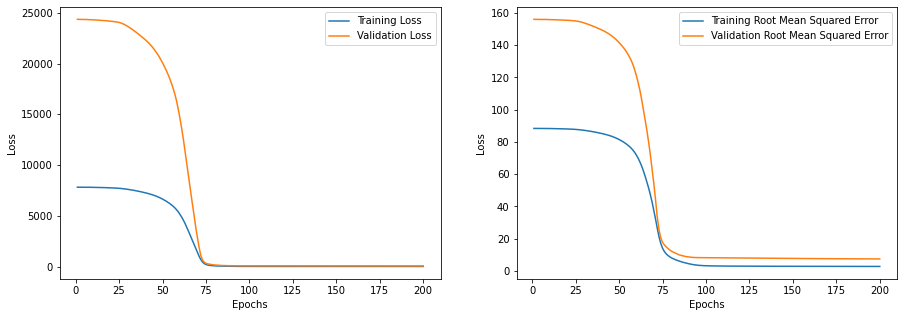

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Prediction

In [77]:
prediction = model.predict(X_test)

5/5 [==============================] - 0s 8ms/step


In [78]:
len(prediction.reshape(-1))

695

In [79]:
temp1 = test.tail(695)

In [80]:
temp1['Forecast'] = prediction.reshape(-1)

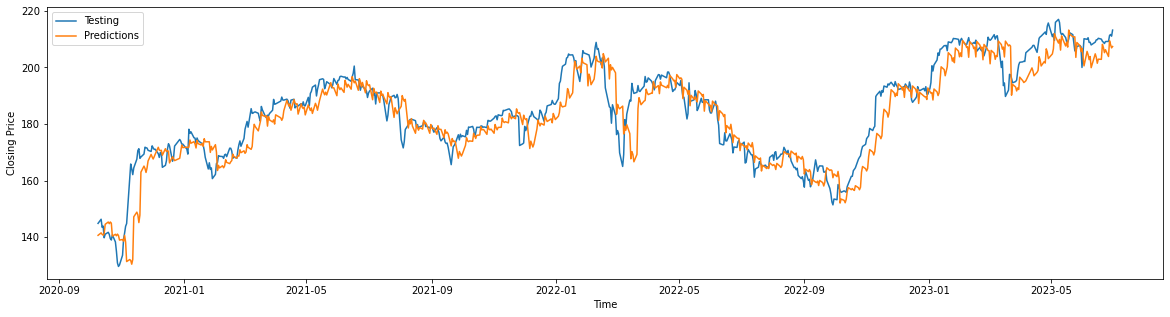

In [81]:
plt.figure(figsize=(20, 5))
plt.plot(temp1['Close'], label = 'Testing')
plt.plot(temp1['Forecast'], label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [82]:
rmse = math.sqrt(mean_squared_error(y_test.reshape(-1, 5), prediction))
mape = np.mean(np.abs(prediction - y_test.reshape(-1, 5))/np.abs(y_test.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 6.392962455756951
MAPE: 0.0253289876578597


In [83]:
temp1

,Close,Forecast
Date,,
2020-10-09,144.838226,140.611725
2020-10-12,146.302643,141.473007
2020-10-13,143.442734,140.966705
2020-10-14,143.873459,140.674271
2020-10-15,139.755890,141.186020
...,...,...
2023-06-26,209.199997,203.861145
2023-06-27,211.300003,209.438019
2023-06-28,211.649994,208.096405


In [84]:
# Extract actual data from SIE
tem1 = ALV['Close'].tolist()[:len(ALV)-695]
# Extract forecasted date from above result
tem2 = temp1['Forecast'].tolist()
# Combine them to a list
tem3 = tem1 + tem2
# Create a column from the resulted list
result1['ALV'] = tem3

In [85]:
result1

,SIE,Forecasted,DTE,ALV
Date,,,,
2010-01-04,39.892437,N,4.953136,45.519119
2010-01-05,39.916805,N,4.911083,45.657921
2010-01-06,40.063042,N,4.789590,46.012665
2010-01-07,40.538315,N,4.698472,45.483131
2010-01-08,40.794235,N,4.724171,45.236355
...,...,...,...,...
2023-06-26,167.921677,Y,25.142923,203.861145
2023-06-27,165.978867,Y,25.438316,209.438019
2023-06-28,166.570953,Y,25.285627,208.096405


## 1.4. MRK

In [86]:
MRK

,Open,High,Low,Close,Volume,Dividends,Stock Splits,pe-ratio,ps-ratio,pb-ratio,Ticker
Date,,,,,,,,,,,
2010-01-04,26.572763,26.780618,26.438271,26.576839,752504.0,0.0,0.0,38.785717,NaN,1.488928,merck-kgaa
2010-01-05,26.527932,26.560537,26.238566,26.381214,488178.0,0.0,0.0,38.785717,NaN,1.488928,merck-kgaa
2010-01-06,26.409742,26.576839,26.140752,26.364910,511138.0,0.0,0.0,38.785717,NaN,1.488928,merck-kgaa
2010-01-07,26.324151,26.972169,26.324151,26.919188,1088580.0,0.0,0.0,38.785717,NaN,1.488928,merck-kgaa
2010-01-08,26.919186,27.053678,26.328226,26.646120,730274.0,0.0,0.0,38.785717,NaN,1.488928,merck-kgaa
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,153.000000,154.399994,152.000000,152.600006,255508.0,0.0,0.0,23.026846,3.467976,3.013593,merck-kgaa
2023-06-27,152.250000,152.600006,147.199997,147.199997,603984.0,0.0,0.0,23.026846,3.467976,3.013593,merck-kgaa
2023-06-28,147.550003,150.699997,147.350006,150.500000,419786.0,0.0,0.0,23.026846,3.467976,3.013593,merck-kgaa


In [87]:
MRK.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3449 entries, 2010-01-04 to 2023-06-30
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3449 non-null   float64
 1   High          3449 non-null   float64
 2   Low           3449 non-null   float64
 3   Close         3449 non-null   float64
 4   Volume        3449 non-null   float64
 5   Dividends     3449 non-null   float64
 6   Stock Splits  3449 non-null   float64
 7   pe-ratio      3449 non-null   float64
 8   ps-ratio      3387 non-null   float64
 9   pb-ratio      3449 non-null   float64
 10  Ticker        3449 non-null   object 
dtypes: float64(10), object(1)
memory usage: 323.3+ KB


In [88]:
MRK_df1 = MRK[["Close"]]
MRK_df1

,Close
Date,
2010-01-04,26.576839
2010-01-05,26.381214
2010-01-06,26.364910
2010-01-07,26.919188
2010-01-08,26.646120
...,...
2023-06-26,152.600006
2023-06-27,147.199997
2023-06-28,150.500000


### Data Proprocessing

In [89]:
# Split data to train set and test set
train, test = split(MRK_df1, end_date, test_start_date)

In [90]:
# Reconcile length of data set and subsets
MRK_df1.shape[0] == train.shape[0] + test.shape[0]

True

In [91]:
# Process data
X_train, y_train = Dataset(train, 1)
X_test, y_test = Dataset(test, 1)

In [92]:
# Split train set to train set and validation set
X_train, X_val = split_val(X_train, 0.8)
y_train, y_val = split_val(y_train, 0.8)

### Model

In [93]:
# Define model (Mehtab et al., 2021)
def Model():
    model = tf.keras.models.Sequential([
                                      tf.keras.layers.LSTM(200, input_shape = (5, 1), activation = tf.nn.leaky_relu, return_sequences = True),
                                      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu, return_sequences = True),                              
                                      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(300, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(5, activation = tf.nn.leaky_relu)
                                      ])
    return model

In [94]:
model = Model()

In [95]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 5, 200)            161600    
                                                                 
 lstm_7 (LSTM)               (None, 5, 200)            320800    
                                                                 
 lstm_8 (LSTM)               (None, 200)               320800    
                                                                 
 dense_12 (Dense)            (None, 300)               60300     
                                                                 
 dense_13 (Dense)            (None, 200)               60200     
                                                                 
 dense_14 (Dense)            (None, 100)               20100     
                                                                 
 dense_15 (Dense)            (None, 50)               

### Custom Learning Rate

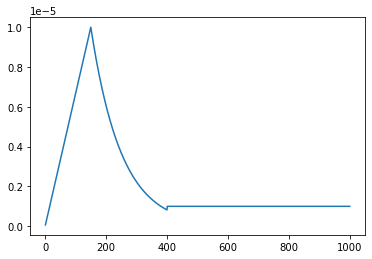

In [96]:
epochs = [i for i in range(1, 1001, 1)]
lrate = [scheduler(i) for i in range(1, 1001, 1)]
plt.plot(epochs, lrate)

In [97]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

### Learning

In [98]:
# Compile model (Mehtab et al., 2021)
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [99]:
# Fit model (Mehtab et al., 2021)
hist = model.fit(X_train, y_train, epochs = 200, validation_data = (X_val, y_val), callbacks=[callback])

Epoch 1/200
14/14 [==============================] - 5s 73ms/step - loss: 3942.7451 - root_mean_squared_error: 62.7913 - val_loss: 9061.0645 - val_root_mean_squared_error: 95.1896 - lr: 0.0000e+00
Epoch 2/200
14/14 [==============================] - 0s 30ms/step - loss: 3942.7363 - root_mean_squared_error: 62.7912 - val_loss: 9061.0137 - val_root_mean_squared_error: 95.1894 - lr: 6.6667e-08
Epoch 3/200
14/14 [==============================] - 1s 37ms/step - loss: 3942.7061 - root_mean_squared_error: 62.7910 - val_loss: 9060.9141 - val_root_mean_squared_error: 95.1888 - lr: 1.3333e-07
Epoch 4/200
14/14 [==============================] - 0s 31ms/step - loss: 3942.6555 - root_mean_squared_error: 62.7906 - val_loss: 9060.7637 - val_root_mean_squared_error: 95.1880 - lr: 2.0000e-07
Epoch 5/200
14/14 [==============================] - 0s 33ms/step - loss: 3942.5845 - root_mean_squared_error: 62.7900 - val_loss: 9060.5625 - val_root_mean_squared_error: 95.1870 - lr: 2.6667e-07
Epoch 6/200
14/

Epoch 84/200
14/14 [==============================] - 0s 34ms/step - loss: 24.1237 - root_mean_squared_error: 4.9116 - val_loss: 30.0889 - val_root_mean_squared_error: 5.4853 - lr: 5.5333e-06
Epoch 85/200
14/14 [==============================] - 1s 36ms/step - loss: 21.1912 - root_mean_squared_error: 4.6034 - val_loss: 26.9829 - val_root_mean_squared_error: 5.1945 - lr: 5.6000e-06
Epoch 86/200
14/14 [==============================] - 1s 38ms/step - loss: 18.8061 - root_mean_squared_error: 4.3366 - val_loss: 24.8745 - val_root_mean_squared_error: 4.9874 - lr: 5.6667e-06
Epoch 87/200
14/14 [==============================] - 0s 36ms/step - loss: 16.9205 - root_mean_squared_error: 4.1135 - val_loss: 23.1181 - val_root_mean_squared_error: 4.8081 - lr: 5.7333e-06
Epoch 88/200
14/14 [==============================] - 1s 35ms/step - loss: 15.4756 - root_mean_squared_error: 3.9339 - val_loss: 22.2352 - val_root_mean_squared_error: 4.7154 - lr: 5.8000e-06
Epoch 89/200
14/14 [====================

Epoch 127/200
14/14 [==============================] - 0s 30ms/step - loss: 6.0434 - root_mean_squared_error: 2.4583 - val_loss: 17.1134 - val_root_mean_squared_error: 4.1368 - lr: 8.4000e-06
Epoch 128/200
14/14 [==============================] - 0s 30ms/step - loss: 6.0077 - root_mean_squared_error: 2.4511 - val_loss: 17.1031 - val_root_mean_squared_error: 4.1356 - lr: 8.4667e-06
Epoch 129/200
14/14 [==============================] - 0s 31ms/step - loss: 6.0434 - root_mean_squared_error: 2.4583 - val_loss: 17.1687 - val_root_mean_squared_error: 4.1435 - lr: 8.5333e-06
Epoch 130/200
14/14 [==============================] - 0s 35ms/step - loss: 5.9621 - root_mean_squared_error: 2.4417 - val_loss: 17.0854 - val_root_mean_squared_error: 4.1335 - lr: 8.6000e-06
Epoch 131/200
14/14 [==============================] - 0s 32ms/step - loss: 5.9141 - root_mean_squared_error: 2.4319 - val_loss: 17.1536 - val_root_mean_squared_error: 4.1417 - lr: 8.6667e-06
Epoch 132/200
14/14 [===================

Epoch 170/200
14/14 [==============================] - 0s 32ms/step - loss: 5.2297 - root_mean_squared_error: 2.2869 - val_loss: 16.1777 - val_root_mean_squared_error: 4.0221 - lr: 8.2696e-06
Epoch 171/200
14/14 [==============================] - 1s 37ms/step - loss: 5.2171 - root_mean_squared_error: 2.2841 - val_loss: 16.0969 - val_root_mean_squared_error: 4.0121 - lr: 8.1873e-06
Epoch 172/200
14/14 [==============================] - 1s 36ms/step - loss: 5.1805 - root_mean_squared_error: 2.2761 - val_loss: 16.1614 - val_root_mean_squared_error: 4.0201 - lr: 8.1058e-06
Epoch 173/200
14/14 [==============================] - 0s 35ms/step - loss: 5.1679 - root_mean_squared_error: 2.2733 - val_loss: 16.0836 - val_root_mean_squared_error: 4.0104 - lr: 8.0252e-06
Epoch 174/200
14/14 [==============================] - 0s 36ms/step - loss: 5.1665 - root_mean_squared_error: 2.2730 - val_loss: 16.0283 - val_root_mean_squared_error: 4.0035 - lr: 7.9453e-06
Epoch 175/200
14/14 [===================

In [100]:
history_dict = hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

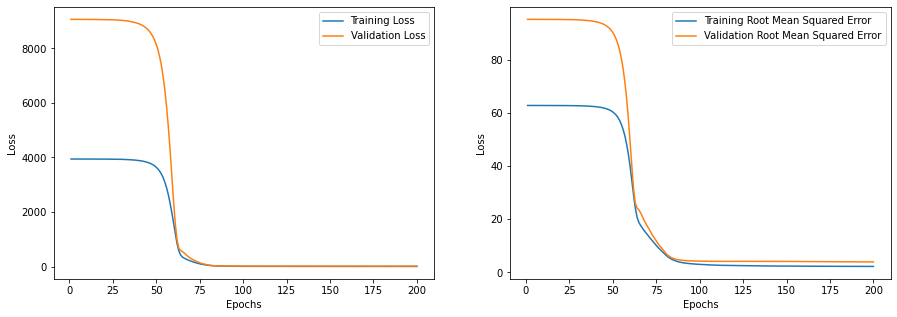

In [101]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Prediction

In [102]:
prediction = model.predict(X_test)

5/5 [==============================] - 1s 12ms/step


In [103]:
len(prediction.reshape(-1))

695

In [104]:
temp1 = test.tail(695)

In [105]:
temp1['Forecast'] = prediction.reshape(-1)

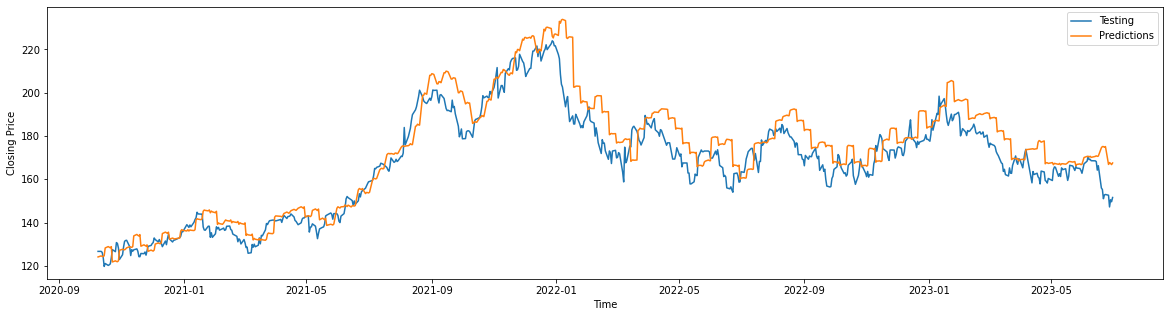

In [106]:
plt.figure(figsize=(20, 5))
plt.plot(temp1['Close'], label = 'Testing')
plt.plot(temp1['Forecast'], label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [107]:
rmse = math.sqrt(mean_squared_error(y_test.reshape(-1, 5), prediction))
mape = np.mean(np.abs(prediction - y_test.reshape(-1, 5))/np.abs(y_test.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 9.313422881523936
MAPE: 0.04325107866031848


In [108]:
temp1

,Close,Forecast
Date,,
2020-10-09,126.661209,124.088409
2020-10-12,126.661209,124.572304
2020-10-13,126.226120,124.334854
2020-10-14,124.098984,124.232826
2020-10-15,119.699684,124.640686
...,...,...
2023-06-26,152.600006,166.832275
2023-06-27,147.199997,167.705566
2023-06-28,150.500000,167.299622


In [109]:
# Extract actual data from SIE
tem1 = MRK['Close'].tolist()[:len(MRK)-695]
# Extract forecasted date from above result
tem2 = temp1['Forecast'].tolist()
# Combine them to a list
tem3 = tem1 + tem2
# Create a column from the resulted list
result1['MRK'] = tem3

In [110]:
result1

,SIE,Forecasted,DTE,ALV,MRK
Date,,,,,
2010-01-04,39.892437,N,4.953136,45.519119,26.576839
2010-01-05,39.916805,N,4.911083,45.657921,26.381214
2010-01-06,40.063042,N,4.789590,46.012665,26.364910
2010-01-07,40.538315,N,4.698472,45.483131,26.919188
2010-01-08,40.794235,N,4.724171,45.236355,26.646120
...,...,...,...,...,...
2023-06-26,167.921677,Y,25.142923,203.861145,166.832275
2023-06-27,165.978867,Y,25.438316,209.438019,167.705566
2023-06-28,166.570953,Y,25.285627,208.096405,167.299622


## 1.5. DHL

In [111]:
DHL

,Open,High,Low,Close,Volume,Dividends,Stock Splits,pe-ratio,ps-ratio,pb-ratio,Ticker
Date,,,,,,,,,,,
2010-01-04,13.550000,13.980000,13.550000,13.980,3020790.0,0.0,0.0,25.443396,NaN,1.970697,deutsche-post
2010-01-05,13.935000,14.135000,13.830000,14.000,2735783.0,0.0,0.0,25.443396,NaN,1.970697,deutsche-post
2010-01-06,13.980000,14.230000,13.925000,14.155,2595800.0,0.0,0.0,25.443396,NaN,1.970697,deutsche-post
2010-01-07,14.110000,14.195000,14.020000,14.125,2907679.0,0.0,0.0,25.443396,NaN,1.970697,deutsche-post
2010-01-08,14.140000,14.525000,14.060000,14.460,5462896.0,0.0,0.0,25.443396,NaN,1.970697,deutsche-post
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,43.435001,43.514999,42.619999,43.000,1812008.0,0.0,0.0,10.613300,0.578296,1.588590,deutsche-post
2023-06-27,43.314999,43.590000,43.174999,43.500,2197942.0,0.0,0.0,10.613300,0.578296,1.588590,deutsche-post
2023-06-28,43.709999,44.415001,43.645000,44.305,1739606.0,0.0,0.0,10.613300,0.578296,1.588590,deutsche-post


In [112]:
DHL.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3441 entries, 2010-01-04 to 2023-06-30
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3441 non-null   float64
 1   High          3441 non-null   float64
 2   Low           3441 non-null   float64
 3   Close         3441 non-null   float64
 4   Volume        3441 non-null   float64
 5   Dividends     3441 non-null   float64
 6   Stock Splits  3441 non-null   float64
 7   pe-ratio      3441 non-null   float64
 8   ps-ratio      3379 non-null   float64
 9   pb-ratio      3441 non-null   float64
 10  Ticker        3441 non-null   object 
dtypes: float64(10), object(1)
memory usage: 322.6+ KB


In [113]:
DHL_df1 = DHL[["Close"]]
DHL_df1

,Close
Date,
2010-01-04,13.980
2010-01-05,14.000
2010-01-06,14.155
2010-01-07,14.125
2010-01-08,14.460
...,...
2023-06-26,43.000
2023-06-27,43.500
2023-06-28,44.305


### Data Proprocessing

In [114]:
# Split data to train set and test set
train, test = split(DHL_df1, end_date, test_start_date)

In [115]:
# Reconcile length of data set and subsets
DHL_df1.shape[0] == train.shape[0] + test.shape[0]

True

In [116]:
# Process data
X_train, y_train = Dataset(train, 1)
X_test, y_test = Dataset(test, 1)

In [117]:
# Split train set to train set and validation set
X_train, X_val = split_val(X_train, 0.8)
y_train, y_val = split_val(y_train, 0.8)

### Model

In [118]:
# Define model (Mehtab et al., 2021)
def Model():
    model = tf.keras.models.Sequential([
                                      tf.keras.layers.LSTM(200, input_shape = (5, 1), activation = tf.nn.leaky_relu, return_sequences = True),
                                      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu, return_sequences = True),
                                      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(300, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(5, activation = tf.nn.leaky_relu)
                                      ])
    return model

In [119]:
model = Model()

In [120]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 5, 200)            161600    
                                                                 
 lstm_10 (LSTM)              (None, 5, 200)            320800    
                                                                 
 lstm_11 (LSTM)              (None, 200)               320800    
                                                                 
 dense_17 (Dense)            (None, 300)               60300     
                                                                 
 dense_18 (Dense)            (None, 200)               60200     
                                                                 
 dense_19 (Dense)            (None, 100)               20100     
                                                                 
 dense_20 (Dense)            (None, 50)               

### Custom Learning Rate

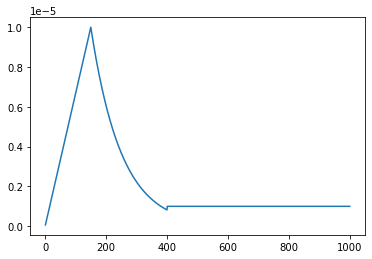

In [121]:
epochs = [i for i in range(1, 1001, 1)]
lrate = [scheduler(i) for i in range(1, 1001, 1)]
plt.plot(epochs, lrate)

In [122]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

### Learning

In [123]:
# Compile model (Mehtab et al., 2021)
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [124]:
# Fit model (Mehtab et al., 2021)
hist = model.fit(X_train, y_train, epochs = 200, validation_data = (X_val, y_val), callbacks=[callback])

Epoch 1/200
14/14 [==============================] - 6s 93ms/step - loss: 577.5787 - root_mean_squared_error: 24.0329 - val_loss: 916.9882 - val_root_mean_squared_error: 30.2818 - lr: 0.0000e+00
Epoch 2/200
14/14 [==============================] - 1s 46ms/step - loss: 577.5768 - root_mean_squared_error: 24.0328 - val_loss: 916.9818 - val_root_mean_squared_error: 30.2817 - lr: 6.6667e-08
Epoch 3/200
14/14 [==============================] - 1s 44ms/step - loss: 577.5706 - root_mean_squared_error: 24.0327 - val_loss: 916.9689 - val_root_mean_squared_error: 30.2815 - lr: 1.3333e-07
Epoch 4/200
14/14 [==============================] - 1s 46ms/step - loss: 577.5600 - root_mean_squared_error: 24.0325 - val_loss: 916.9492 - val_root_mean_squared_error: 30.2812 - lr: 2.0000e-07
Epoch 5/200
14/14 [==============================] - 1s 45ms/step - loss: 577.5445 - root_mean_squared_error: 24.0322 - val_loss: 916.9224 - val_root_mean_squared_error: 30.2807 - lr: 2.6667e-07
Epoch 6/200
14/14 [======

Epoch 43/200
14/14 [==============================] - 1s 46ms/step - loss: 568.7074 - root_mean_squared_error: 23.8476 - val_loss: 901.2255 - val_root_mean_squared_error: 30.0204 - lr: 2.8000e-06
Epoch 44/200
14/14 [==============================] - 1s 46ms/step - loss: 567.6055 - root_mean_squared_error: 23.8245 - val_loss: 899.1943 - val_root_mean_squared_error: 29.9866 - lr: 2.8667e-06
Epoch 45/200
14/14 [==============================] - 1s 41ms/step - loss: 566.3418 - root_mean_squared_error: 23.7979 - val_loss: 896.7386 - val_root_mean_squared_error: 29.9456 - lr: 2.9333e-06
Epoch 46/200
14/14 [==============================] - 1s 45ms/step - loss: 564.8133 - root_mean_squared_error: 23.7658 - val_loss: 893.8755 - val_root_mean_squared_error: 29.8978 - lr: 3.0000e-06
Epoch 47/200
14/14 [==============================] - 1s 46ms/step - loss: 562.9699 - root_mean_squared_error: 23.7270 - val_loss: 890.5021 - val_root_mean_squared_error: 29.8413 - lr: 3.0667e-06
Epoch 48/200
14/14 [

Epoch 85/200
14/14 [==============================] - 1s 51ms/step - loss: 54.4915 - root_mean_squared_error: 7.3818 - val_loss: 28.9335 - val_root_mean_squared_error: 5.3790 - lr: 5.6000e-06
Epoch 86/200
14/14 [==============================] - 1s 48ms/step - loss: 41.9583 - root_mean_squared_error: 6.4775 - val_loss: 15.3482 - val_root_mean_squared_error: 3.9177 - lr: 5.6667e-06
Epoch 87/200
14/14 [==============================] - 1s 48ms/step - loss: 34.0120 - root_mean_squared_error: 5.8320 - val_loss: 8.9983 - val_root_mean_squared_error: 2.9997 - lr: 5.7333e-06
Epoch 88/200
14/14 [==============================] - 1s 48ms/step - loss: 29.3861 - root_mean_squared_error: 5.4209 - val_loss: 6.8875 - val_root_mean_squared_error: 2.6244 - lr: 5.8000e-06
Epoch 89/200
14/14 [==============================] - 1s 45ms/step - loss: 26.6452 - root_mean_squared_error: 5.1619 - val_loss: 5.8435 - val_root_mean_squared_error: 2.4173 - lr: 5.8667e-06
Epoch 90/200
14/14 [=======================

Epoch 128/200
14/14 [==============================] - 1s 42ms/step - loss: 2.2110 - root_mean_squared_error: 1.4869 - val_loss: 2.2158 - val_root_mean_squared_error: 1.4886 - lr: 8.4667e-06
Epoch 129/200
14/14 [==============================] - 1s 44ms/step - loss: 2.1031 - root_mean_squared_error: 1.4502 - val_loss: 2.2006 - val_root_mean_squared_error: 1.4835 - lr: 8.5333e-06
Epoch 130/200
14/14 [==============================] - 1s 42ms/step - loss: 2.0056 - root_mean_squared_error: 1.4162 - val_loss: 2.1656 - val_root_mean_squared_error: 1.4716 - lr: 8.6000e-06
Epoch 131/200
14/14 [==============================] - 1s 46ms/step - loss: 1.9184 - root_mean_squared_error: 1.3851 - val_loss: 2.1288 - val_root_mean_squared_error: 1.4590 - lr: 8.6667e-06
Epoch 132/200
14/14 [==============================] - 1s 46ms/step - loss: 1.8322 - root_mean_squared_error: 1.3536 - val_loss: 2.1158 - val_root_mean_squared_error: 1.4546 - lr: 8.7333e-06
Epoch 133/200
14/14 [========================

Epoch 171/200
14/14 [==============================] - 1s 42ms/step - loss: 0.7879 - root_mean_squared_error: 0.8877 - val_loss: 1.8284 - val_root_mean_squared_error: 1.3522 - lr: 8.1873e-06
Epoch 172/200
14/14 [==============================] - 1s 43ms/step - loss: 0.7895 - root_mean_squared_error: 0.8885 - val_loss: 1.8657 - val_root_mean_squared_error: 1.3659 - lr: 8.1058e-06
Epoch 173/200
14/14 [==============================] - 1s 46ms/step - loss: 0.7850 - root_mean_squared_error: 0.8860 - val_loss: 1.8226 - val_root_mean_squared_error: 1.3500 - lr: 8.0252e-06
Epoch 174/200
14/14 [==============================] - 1s 46ms/step - loss: 0.7715 - root_mean_squared_error: 0.8783 - val_loss: 1.8389 - val_root_mean_squared_error: 1.3561 - lr: 7.9453e-06
Epoch 175/200
14/14 [==============================] - 1s 44ms/step - loss: 0.7698 - root_mean_squared_error: 0.8774 - val_loss: 1.8237 - val_root_mean_squared_error: 1.3505 - lr: 7.8663e-06
Epoch 176/200
14/14 [========================

In [125]:
history_dict = hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

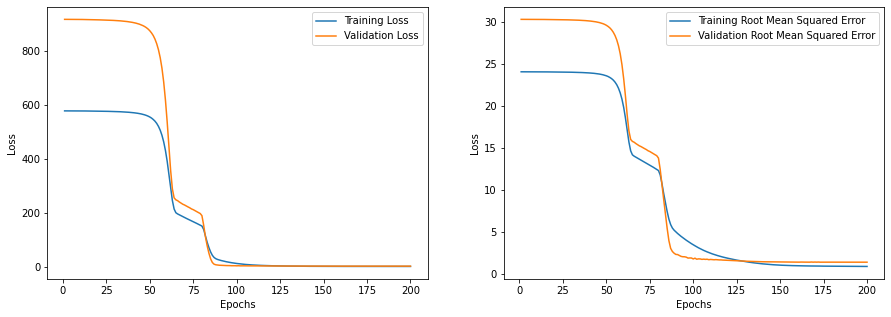

In [126]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Prediction

In [127]:
prediction = model.predict(X_test)

5/5 [==============================] - 1s 17ms/step


In [128]:
len(prediction.reshape(-1))

695

In [129]:
temp1 = test.tail(695)

In [130]:
temp1['Forecast'] = prediction.reshape(-1)

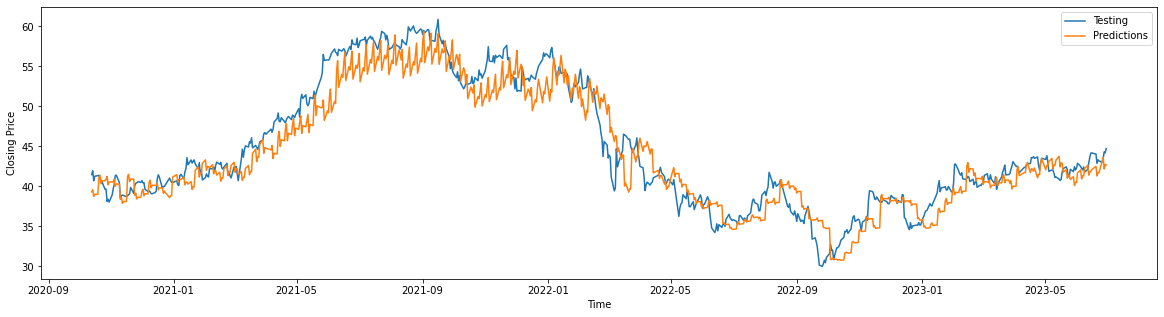

In [131]:
plt.figure(figsize=(20, 5))
plt.plot(temp1['Close'], label = 'Testing')
plt.plot(temp1['Forecast'], label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [132]:
rmse = math.sqrt(mean_squared_error(y_test.reshape(-1, 5), prediction))
mape = np.mean(np.abs(prediction - y_test.reshape(-1, 5))/np.abs(y_test.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 2.164604884763302
MAPE: 0.037161308056457655


In [133]:
temp1

,Close,Forecast
Date,,
2020-10-13,41.470001,39.314884
2020-10-14,41.950001,39.584259
2020-10-15,40.709999,38.750683
2020-10-16,41.270000,39.004848
2020-10-19,41.340000,39.012074
...,...,...
2023-06-26,43.000000,43.135433
2023-06-27,43.500000,43.623661
2023-06-28,44.305000,42.174179


In [134]:
# Extract actual data from SIE
tem1 = DHL['Close'].tolist()[:len(DHL)+8-695]
# Extract forecasted date from above result
tem2 = temp1['Forecast'].tolist()
# Combine them to a list
tem3 = tem1 + tem2
# Create a column from the resulted list
result1['DHL'] = tem3

In [135]:
result1

,SIE,Forecasted,DTE,ALV,MRK,DHL
Date,,,,,,
2010-01-04,39.892437,N,4.953136,45.519119,26.576839,13.980000
2010-01-05,39.916805,N,4.911083,45.657921,26.381214,14.000000
2010-01-06,40.063042,N,4.789590,46.012665,26.364910,14.155000
2010-01-07,40.538315,N,4.698472,45.483131,26.919188,14.125000
2010-01-08,40.794235,N,4.724171,45.236355,26.646120,14.460000
...,...,...,...,...,...,...
2023-06-26,167.921677,Y,25.142923,203.861145,166.832275,43.135433
2023-06-27,165.978867,Y,25.438316,209.438019,167.705566,43.623661
2023-06-28,166.570953,Y,25.285627,208.096405,167.299622,42.174179


In [136]:
# Define the desired column order
desired_order = ['SIE', 'DTE', 'ALV', 'MRK', 'DHL', 'Forecasted']

# Rearrange columns
result = result1[desired_order]
result

,SIE,DTE,ALV,MRK,DHL,Forecasted
Date,,,,,,
2010-01-04,39.892437,4.953136,45.519119,26.576839,13.980000,N
2010-01-05,39.916805,4.911083,45.657921,26.381214,14.000000,N
2010-01-06,40.063042,4.789590,46.012665,26.364910,14.155000,N
2010-01-07,40.538315,4.698472,45.483131,26.919188,14.125000,N
2010-01-08,40.794235,4.724171,45.236355,26.646120,14.460000,N
...,...,...,...,...,...,...
2023-06-26,167.921677,25.142923,203.861145,166.832275,43.135433,Y
2023-06-27,165.978867,25.438316,209.438019,167.705566,43.623661,Y
2023-06-28,166.570953,25.285627,208.096405,167.299622,42.174179,Y


In [137]:
result.to_csv('LSTM_1 feature.csv', index=True)

# Bibliography

- Mehtab, S., Sen, J., & Dutta, A. (2021). Stock price prediction using machine learning and LSTM-based deep learning models. In _Machine Learning and Metaheuristics Algorithms, and Applications: Second Symposium, SoMMA 2020, Chennai, India, October 14–17, 2020, Revised Selected Papers 2_ (pp. 88-106). Springer Singapore.